## Word Embeddings in Action - Word2Vec

 - Word embeddings are a really useful way of converting text into a format that is interpretable to the model while still keeping it's semantic meaning intact.
 - Now that you have already learnt the theory behind Word2Vec, in this notebook you will learn how to utilize it practically on a real-world data set.
 
With the expectation set, let's start without much ado!

![](https://www.tensorflow.org/images/linear-relationships.png)
 
### Table of Contents
 
1. About the dataset
2. Creating your own Word2Vec model
    - Installing gensim
    - Preprocess text
    - Train Word2Vec
    - Embedding of a given word
    - Find contextually similar words; given a target word
    - Why to train your own Word2Vec?
3. Visualizing Word2Vec embeddings 
4. Utilizing Google's pretrained Word2Vec
    - Installing
    - Contextual relationship between words 
5. Text Classification using Word2Vec
    - Using your own model
    - Using Google's pre-trained model
6. Conclusion

### 1. About the Dataset

The dataset that you are going to use is a collection of news articles from BBC across 5 major categories, namely:
 
 - Business
 - Entertainment
 - Politics
 - Sport
 - Tech

There are a total of 2225 articles in the dataset, which is a mix of all of the above categories. Let's load the dataset using pandas and have a quick look at some of the articles. 

**Note:** You can get the dataset [here](https://trainings.analyticsvidhya.com/asset-v1:AnalyticsVidhya+LP_DL_2019+2019_T1+type@asset+block@bbc_news_mixed.csv)


In [1]:
import pandas as pd
import numpy as np

# Load the dataset
bbc_news = pd.read_csv('../datasets/bbc_news_mixed.csv')
bbc_news.head()

,text,label
0,Cairn shares slump on oil setback\n\nShares in...,business
1,Egypt to sell off state-owned bank\n\nThe Egyp...,business
2,Cairn shares up on new oil find\n\nShares in C...,business
3,Low-cost airlines hit Eurotunnel\n\nChannel Tu...,business
4,"Parmalat to return to stockmarket\n\nParmalat,...",business


In [71]:
# print first 2 articles
for art in bbc_news.text[:2]:
    print(art[:200])

Cairn shares slump on oil setback

Shares in Cairn Energy, a UK oil firm, have closed down 18% after a disappointing drilling update and a warning over possible tax demands.

The company said tests ha
Egypt to sell off state-owned bank

The Egyptian government is reportedly planning to privatise one of the country's big public banks.

An Investment Ministry official has told the Reuters news agency


Now that you have an idea of how your data looks like, let's see the count of each category in the dataset!

In [3]:
# category-wise count
bbc_news.label.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: label, dtype: int64

### 2. Creating your own Word2Vec model

 - [Word2Vec](https://code.google.com/archive/p/word2vec/) is an embedding that was developed at Google and has proven to be very effective for various NLP tasks.
 - For this tutorial, you'll be using [gensim](https://radimrehurek.com/gensim/index.html) which is an NLP library that provides an easier way to work with Word2Vec.
 
#### a. Installing gensim

Installing gensim is fairly easy, you can follow the following steps for installation: 

1. Go to your terminal and type

  `pip install --upgrade gensim`

2. Once you have run the above command succesfully, you are ready to go!

#### b. Preprocess text

 - Gensim provides a utility `simple_preprocess()` that performs basic preprocessing such as lower casing the text, tokenizing and ignoring tokens that are too small(lenght of 2) or too big(length of 15) in the corpus. 
 - Note that you can choose these values(2 and 15) by passing the `min_len` and `max_len` parameters to the function. 
 
Let's preprocess the first news article and see the output.

In [72]:
# importing simple_preprocess
from gensim.utils import simple_preprocess

# check the output of simple_preprocess on the first article
print(simple_preprocess(bbc_news.text[0])[:200])

['cairn', 'shares', 'slump', 'on', 'oil', 'setback', 'shares', 'in', 'cairn', 'energy', 'uk', 'oil', 'firm', 'have', 'closed', 'down', 'after', 'disappointing', 'drilling', 'update', 'and', 'warning', 'over', 'possible', 'tax', 'demands', 'the', 'company', 'said', 'tests', 'had', 'shown', 'no', 'significant', 'finds', 'in', 'one', 'of', 'its', 'indian', 'oil', 'fields', 'but', 'was', 'upbeat', 'about', 'the', 'potential', 'of', 'other', 'areas', 'it', 'also', 'said', 'the', 'indian', 'government', 'had', 'told', 'it', 'to', 'pay', 'production', 'tax', 'for', 'which', 'cairn', 'argues', 'it', 'is', 'not', 'liable', 'cairn', 'shares', 'have', 'jumped', 'by', 'almost', 'this', 'year', 'investors', 'had', 'piled', 'into', 'cairn', 'after', 'the', 'company', 'announced', 'significant', 'oil', 'finds', 'in', 'india', 'this', 'year', 'chief', 'executive', 'bill', 'gammell', 'said', 'on', 'friday', 'he', 'was', 'disappointed', 'with', 'exploration', 'in', 'the', 'so', 'called', 'extension', 'a

As you can see, the article has been tokenized, words are converted to lower case for consistency and you can use this little utility for quick preprocessing in your projects. Let's preprocess articles of the entire dataset.

In [5]:
# preprocess all the articles of the data set
preprocessed_bbc = bbc_news.text.apply(lambda x: simple_preprocess(x))
preprocessed_bbc[:10]

0    [cairn, shares, slump, on, oil, setback, share...
1    [egypt, to, sell, off, state, owned, bank, the...
2    [cairn, shares, up, on, new, oil, find, shares...
3    [low, cost, airlines, hit, eurotunnel, channel...
4    [parmalat, to, return, to, stockmarket, parmal...
5    [making, your, office, work, for, you, our, mi...
6    [mexican, in, us, send, bn, home, mexican, lab...
7    [asia, shares, defy, post, quake, gloom, indon...
8    [german, bidder, in, talks, with, lse, deutsch...
9    [bank, payout, to, pinochet, victims, us, bank...
Name: text, dtype: object

#### c. Train Word2Vec

There are many parameters that can be utilized while training this model in gensim; some of the important ones are:

 - **size**: (default 100) The number of dimensions of the embedding, e.g. the length of the dense vector to represent each token (word).
 - **window**: (default 5) The maximum distance between a target word and words around the target word.
 - **min_count**: (default 5) The minimum count of words to consider when training the model; words with an occurrence less than this count will be ignored.
 - **sg**: (default 0 or CBOW) The training algorithm, either CBOW (0) or skip gram (1).
 
In the following case, you will be using an embedding of size 300 and will be training a **skip gram** variant of word2vec which means given a center word, the model should be able to predict words that fall in the context of the center word.

In [6]:
# import word2vec
from gensim.models import Word2Vec

# train a word2vec model from the given data set
w2v_model = Word2Vec(preprocessed_bbc, size=300, min_count=2, sg=1)

Now that the model is trained, you can play around with it a bit.

Let's start by checking the vocabulary size and some of the words of the vocabulary.

In [7]:
# vocabulary size
print('vocabulary size:', len(w2v_model.wv.vocab))

vocabulary size: 18588


In [80]:
# vocabulary
list(w2v_model.wv.vocab.items())[:20]

[('cairn', <gensim.models.keyedvectors.Vocab at 0x7f61777cc240>),
 ('shares', <gensim.models.keyedvectors.Vocab at 0x7f61777cc390>),
 ('slump', <gensim.models.keyedvectors.Vocab at 0x7f61777cc320>),
 ('on', <gensim.models.keyedvectors.Vocab at 0x7f61777cc278>),
 ('oil', <gensim.models.keyedvectors.Vocab at 0x7f61777cc400>),
 ('setback', <gensim.models.keyedvectors.Vocab at 0x7f61777cc358>),
 ('in', <gensim.models.keyedvectors.Vocab at 0x7f61777cc470>),
 ('energy', <gensim.models.keyedvectors.Vocab at 0x7f61777cc4a8>),
 ('uk', <gensim.models.keyedvectors.Vocab at 0x7f61777cc4e0>),
 ('firm', <gensim.models.keyedvectors.Vocab at 0x7f61777cc588>),
 ('have', <gensim.models.keyedvectors.Vocab at 0x7f61777cc550>),
 ('closed', <gensim.models.keyedvectors.Vocab at 0x7f61777cc518>),
 ('down', <gensim.models.keyedvectors.Vocab at 0x7f61777cc5c0>),
 ('after', <gensim.models.keyedvectors.Vocab at 0x7f61777cc5f8>),
 ('disappointing', <gensim.models.keyedvectors.Vocab at 0x7f61777cc630>),
 ('drilling

#### d. Embedding of a given word

Now that you have trained your own Word2Vec, you can fetch the embedding of a given word by the following way. Notice that each word will be represented by a vector of **300** dimensions because this is the paremeter you passed while training.

In [82]:
# get trained embedding of the word 'warning'
print('shape of \'warning\' vector:', w2v_model.wv.get_vector('warning').shape)

shape of 'warning' vector: (300,)


#### e. Find contextually similar words; given a target word

Now since you have trained the **Word2Vec** model, you can easily utilize this model to predict a list of words that are most similar to a given word based on it's context in the corpus.

In [10]:
# find the words that are most similar to the word 'oil'
words_oil = w2v_model.wv.most_similar('oil')
words_oil

[('gas', 0.8974010944366455),
 ('giant', 0.8179374933242798),
 ('fuel', 0.8141058683395386),
 ('telecoms', 0.8004088401794434),
 ('energy', 0.7998166084289551),
 ('china', 0.7957749366760254),
 ('production', 0.7957689762115479),
 ('steel', 0.7839666604995728),
 ('rapid', 0.77938312292099),
 ('revenue', 0.7784941792488098)]

In [11]:
# find the words that are most similar to the word 'pc'
words_pc = w2v_model.wv.most_similar('pc')
words_pc

[('computer', 0.8795419931411743),
 ('desktop', 0.8555729389190674),
 ('machine', 0.8405307531356812),
 ('pocket', 0.8396756649017334),
 ('elements', 0.8348112106323242),
 ('copy', 0.8306844830513),
 ('graphics', 0.828892707824707),
 ('audio', 0.8194856643676758),
 ('computers', 0.8182631134986877),
 ('hardware', 0.8161558508872986)]

**Note:** 
 - You'd have noticed that the model is working pretty well given that it has only been trained on a small dataset of 2225 news articles and a vocabulary of 18588 words!
 - Searching for 'oil' returned entries like 'gas', 'energy' etc. with a high similarity score
 - Similarly when searched with 'pc', it returned entries like 'computer', 'machine', 'desktop' etc.
 
#### f. Why to train your own embedding?

 - While you will learn in further sections that Google also provides a pre-trained Word2Vec that you can utilize for a project, there are some benefits of training your own model too.
 - One of them is that the word vectors would be derived from your dataset, so if you have reason to believe that the composition of your data is significantly different from the corpus used for the pre-trained vectors then that may result in better performance. 
 - A good example would be if you are trying to build a model on Medical related data wherein there can be many terminilogies that won't be present in Word2Vec's training corpus then you'd surely have to train the model on your own corpus.
 - A thing to keep in mind while deciding is that training your own model is usually time and compute heavy.

### 3. Visualizing Word2Vec embeddings

One of the most effective ways of understanding how word embeddings like Word2Vec work is to visualize them on a graph. Now that you have a newly trained Word2Vec model, you will go ahead and try to plot the same on a graph and then compare how do they work.

In [12]:
# generate similar word lists
words_music = w2v_model.wv.most_similar('music')
words_football = w2v_model.wv.most_similar('football')

# combine word lists 
words = words_oil + words_music + words_football

# extract only the word and not the similarity score
words = list(map(lambda x: x[0], words))

In [13]:
from matplotlib import pyplot
from sklearn.decomposition import PCA

# plots w2v embeddings of a given word list
def plot_w2v(word_list):
    X = w2v_model[word_list]
    
    # reduce dimensions to 2
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    
    # create a scatter plot of the projection
    pyplot.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(word_list):
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
        
    # show
    pyplot.figure(figsize=(6,15))
    pyplot.show()

**Note:** 

 - In order to plot the word embeddings on a X-Y axis, you need to reduce the dimensions from 300 to 2(X,Y) and for that purpose [PCA](https://www.analyticsvidhya.com/blog/2016/03/practical-guide-principal-component-analysis-python/) is used. Don't worry about it much right now.
 - Let's have a look at the plot!


/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


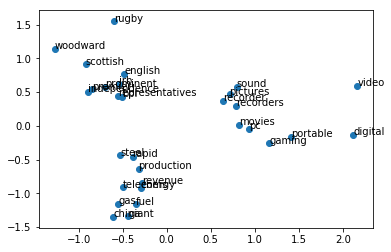

In [14]:
# plot w2v embeddings
plot_w2v(words)

**Note:**
 - You have plotted word2vec of 3 topics: namely 'oil', 'music' and 'football'. Notice that all the words have roughly been aligned into 3 major clusters.
 - Words like 'scottish', 'rugby', 'premier' and 'pro' fall in the 'football' cluster.
 - Words like 'energy', 'fuel', 'gas' fall in the 'oil' cluster.
 - Words like 'sound', 'audio', 'recorders' fall in the 'music' cluster.
 
The above visualization gives an intution of how Word2Vec is able to give such good results by representing the words into higher dimensional vector space.

### 4. Utilizing Google's pre-trained Word2Vec

 - Training your own Word2Vec might be needed for some NLP problems but it comes with several overheads like computation power, need of a large training corpus and training time.
 - Google has released a pre-trained Word2Vec model that has the advantage of being trained on **Google's News data set of 3 million words**.
 - Most of the NLP tasks can be solved by using some variant of this pre-trained model. Hence, in this section you will learn how to install and utilize it.

#### a. Installing

 - Once you have finished downloading, you need to decompress the file by the following command.
 
 `gzip -d GoogleNews-vectors-negative300.bin.gz`
 - Now that you have the model downloaded and ready, let's see how to import it in Gensim.

In [15]:
from gensim.models import KeyedVectors

# path of the downloaded model
filename = '../embeddings/GoogleNews-vectors-negative300.bin'
# load into gensim
w2vec = KeyedVectors.load_word2vec_format(filename, binary=True)

Once you have executed the above code, your word2vec model is finally installed and loaded in gensim. Let's explore some of the features of this model.

#### b. Contextual relationship between words

 - One of the impressive things about word2vec is it's ability to capture semantic relationship between words. That is the reason that you can do cool stuff like perform linear algebra on words and get an appropriate output. Have a look at the following example:

    `airplane - fly + drive = car`

 - If you pass the left hand side of the above equation to the model, it will give the right handside. Which makes sense because what would you get if you remove the ability to fly from an airplane? And add the ability to drive? You would get a car!
 - The underlying model is able to understand implicit relationship between airplane and fly and also how removing the medium of travel changes the machine used to travel. 
 - It is also able to understand **how what fly is to airplane similarly drive is to a car.**

In [20]:
# airplane - fly + drive
w2vec.most_similar(positive=['airplane', 'drive'], negative=['fly'], topn=5)

[('car', 0.511200487613678),
 ('drives', 0.47777241468429565),
 ('automobile', 0.45616623759269714),
 ('vehicle', 0.44856154918670654),
 ('SUV', 0.44360122084617615)]

Here are a few other examples

1. `king - man + woman = queen`
Removing man from kind and adding woman gives queen.
2. `moscow - russia + japan = tokyo`
Removing russia from moscow(capital of russia) and adding japan gives tokyo(capital of japan)

In [33]:
# king - man + woman
print(w2vec.most_similar(positive=['king', 'woman'], negative=['man'], topn=5))
# moscow - russia + japan
print(w2vec.most_similar(positive=['moscow', 'japan'], negative=['russia'], topn=5))

[('queen', 0.7118192911148071), ('monarch', 0.6189674139022827), ('princess', 0.5902431607246399), ('crown_prince', 0.5499460697174072), ('prince', 0.5377321243286133)]
[('tokyo', 0.49488699436187744), ('hawaii', 0.4802300035953522), ('malta', 0.4749153256416321), ('japanese', 0.45723214745521545), ('seattle', 0.4502826929092407)]


### 5. Text Classification using Word2Vec

Let's now get back to our BBC News data set, here you are going to solve the same problem that was solved in **Count Vector, TFIDF Representations of Text** NB by using Word2Vec as a text feature.

 - Word2Vec gives vector representation of individual words, in order to find the same for a statement or a document you can mean the vectors of it's words.
 - This is what is being done in the `get_embedding_w2v()`. It iterates through all the words in a document/statement and extracts the vector for them if they are present in the vocabulary of the word2vec model.


In [62]:
# returns vector reperesentation of a given word if it is present in vocabulary
def get_embedding_w2v(doc_tokens, pre_trained):
    embeddings = []
    # if pre_trained = 1; use Google's model else use our own model
    if pre_trained:
        model = w2vec
    else:
        model = w2v_model
    # iterate over tokens to extract their vectors    
    for tok in doc_tokens:
        if tok in model.wv.vocab:
            embeddings.append(model.wv.word_vec(tok))
    # mean the vectors of individual words to get the vector of the statement
    return np.mean(embeddings, axis=0)

**Note:**
- Now that is done, you will be doing a bit of preprocessing of the dataset and splitting it in train and test sets just like what you have been doing till now.
- Let's first build a model on the model you initially trained yourself. We will then compare the results from both the models.

#### a. Using your own model

 - Generate vector representation for each document. Note that here `pre_trained=0` should be used.
 - Label encode the prediction column ('label').
 - Create the X data set and split it into train and test sets.
 - Train a text classification (Naive Bayes) model and compute it's accuracy.

In [66]:
# general preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# create X from w2vec
X_w2v_model = preprocessed_bbc.apply(lambda x: get_embedding_w2v(x, pre_trained=0))
X_w2v_model = pd.DataFrame(X_w2v_model.tolist())
print('X shape:', X_w2v_model.shape)


# label encode the 'label' 
lencod = LabelEncoder()
# fit_transform() converts the text to numbers
bbc_news.label = lencod.fit_transform(bbc_news.label)

# split into train and test
y = bbc_news.label
X_train_wm, X_test_wm, y_train_wm, y_test_wm = train_test_split(X_w2v_model, y, test_size=0.2, random_state=42)

X shape: (2225, 300)


In [69]:
# build a text classification model
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Initialize GaussianNB classifier
model_1 = GaussianNB()
# Fit the model on the train dataset
model_1 = model_1.fit(X_train_wm, y_train_wm)
# Make predictions on the test dataset
pred_1 = model_1.predict(X_test_wm)

# check the accuracy of the model
print("Accuracy:", accuracy_score(y_test_wm, pred_1)*100, "%")

Accuracy: 89.8876404494382 %


#### b. Using Google's pre-trained model

 - Generate vector representation for each document. Note that here `pre_trained=1` should be used.
 - Create the X data set and split it into train and test sets.
 - Train a text classification (Naive Bayes) model and compute it's accuracy.

In [68]:
# general preprocessing
from sklearn.model_selection import train_test_split

# create X from w2vec
X_w2v = preprocessed_bbc.apply(lambda x: get_embedding_w2v(x, pre_trained=1))
X_w2v = pd.DataFrame(X_w2v.tolist())
print('X shape:', X_w2v.shape)

# split into train and test
y = bbc_news.label
X_train_wv, X_test_wv, y_train_wv, y_test_wv = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if sys.path[0] == '':


X shape: (2225, 300)


In [70]:
# build a text classification model
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Initialize GaussianNB classifier
model_2 = GaussianNB()
# Fit the model on the train dataset
model_2 = model_2.fit(X_train_wv, y_train_wv)
# Make predictions on the test dataset
pred_2 = model_2.predict(X_test_wv)

# check the accuracy of the model
print("Accuracy:", accuracy_score(y_test_wv, pred_2)*100, "%")

Accuracy: 92.80898876404494 %


### 6. Conclusion

 - The accuracy of using Google's pre-trained model (92.8 %) is higher than our own model's (89.8 %); this is because we have trained on a small vocabulary of around 18,000 words while the other has been trained on a rich vocabulary of 3 million words. The more rich the vocabulary is, the better the model generates the semantic vectors of a word.
 
 - Notice that the current accuracy can be improved further by parameter tuning the model or using a more complex model.
 - We covered a lot in this notebook, I hope that you know have a solid understanding of Word2Vec can be used in real world projects and hopefully you got an idea on how to efficiently code it.
 - Next we will take a closer look on another embedding: Glove which is designed by Stanford.